# Economic Shock Resilience Predictor - Phase 3: Advanced Modeling Pipeline

# Business Context:
- Stakeholders: Policy makers, central banks, IMF, World Bank, investment firms
- Business Value: Enable proactive policy interventions and risk management
- Success Metrics: Accurate prediction of growth stability

# Data Context (from EDA):
- 1,292 observations across 38 countries (1990-2023)
- 78 engineered features 
- Target: Economic Growth Stability (varies by year)- Inverse coefficient of variation of GDP growth (more stable = higher score)
- Advanced feature engineering already completed in previous phase

In [6]:
# =============================================================================
# ECONOMIC RESILIENCE MODELING 
# Focus: Growth Stability Prediction (Target: R² > 0.90)
# =============================================================================

# ENVIRONMENT SETUP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Advanced models (if available)
try:
    import xgboost as xgb
    import lightgbm as lgb
    ADVANCED_AVAILABLE = True
    print("XGBoost and LightGBM available")
except ImportError:
    ADVANCED_AVAILABLE = False
    print("⚠️ Advanced models not available (XGBoost/LightGBM)")

print("ECONOMIC RESILIENCE MODELING - PIPELINE")
print("=" * 60)
print("Target: growth_stability_target prediction")


XGBoost and LightGBM available
ECONOMIC RESILIENCE MODELING - PIPELINE
Target: growth_stability_target prediction


In [7]:
#  DATA LOADING SOLUTION
# =============================================================================

import pandas as pd
import numpy as np
from pathlib import Path
import os

def load_engineered_dataset():
    """
    Robust loading function that tries multiple common locations.
    
    Returns:
        DataFrame: The engineered features dataset
    """
    # List of possible file locations (add your specific paths)
    possible_paths = [
        # Your specific path
        '/Users/laurarojas/Documents/DataScience/DS_CapstoneProjects/modern_economic_resilience/data/engineered_features_dataset.csv',
        
        # Common relative paths
        'data/engineered_features_dataset.csv',
        './data/engineered_features_dataset.csv',
        '../data/engineered_features_dataset.csv',
        'engineered_features_dataset.csv',
        './engineered_features_dataset.csv',
        
        # Alternative names in case of variations
        'data/engineered_dataset.csv',
        'engineered_dataset.csv'
    ]
    
    print("  SEARCHING FOR ENGINEERED DATASET...")
    
    # Try each path
    for path in possible_paths:
        try:
            if os.path.exists(path):
                print(f" Found dataset at: {path}")
                df = pd.read_csv(path)
                
                # Validate the dataset
                print(f"   Dataset loaded successfully:")
                print(f"   Shape: {df.shape}")
                print(f"   Columns: {df.shape[1]}")
                
                # Check for our target variable
                if 'growth_stability_target' in df.columns:
                    print(f"  Target variable 'growth_stability_target' found!")
                    target_stats = df['growth_stability_target'].describe()
                    print(f"   Range: {target_stats['min']:.3f} - {target_stats['max']:.3f}")
                    print(f"   Mean: {target_stats['mean']:.3f}")
                else:
                    print(f"⚠️  Target variable 'growth_stability_target' not found")
                    print(f"   Available targets: {[col for col in df.columns if 'target' in col]}")
                
                return df
                
        except Exception as e:
            print(f" Failed to load from {path}: {e}")
            continue
    
    # If no file found, provide helpful guidance
    print(f"\n DATASET NOT FOUND IN ANY EXPECTED LOCATION")
    print(f"🔧 MANUAL LOADING INSTRUCTIONS:")
    print(f"   1. Check your current working directory: {os.getcwd()}")
    print(f"   2. List files in current directory:")
    
    # List CSV files in current directory
    current_dir = Path('.')
    csv_files = list(current_dir.glob('*.csv'))
    if csv_files:
        print(f"      CSV files found:")
        for csv_file in csv_files:
            print(f"        • {csv_file}")
    else:
        print(f"      No CSV files in current directory")
    
    print(f"\n   3. Update the path below with your actual file location:")
    print(f"      df = pd.read_csv('YOUR_ACTUAL_PATH_HERE')")
    
    # Return None so user knows to fix the path
    return None

In [8]:
df = load_engineered_dataset()  # Make sure this function is available

if df is None:
    raise Exception(" Data loading failed. Run EDA notebook first or update file path.")

print(f" Data loaded: {df.shape}")

  SEARCHING FOR ENGINEERED DATASET...
 Found dataset at: /Users/laurarojas/Documents/DataScience/DS_CapstoneProjects/modern_economic_resilience/data/engineered_features_dataset.csv
   Dataset loaded successfully:
   Shape: (1292, 78)
   Columns: 78
  Target variable 'growth_stability_target' found!
   Range: 0.005 - 81.532
   Mean: 4.658
 Data loaded: (1292, 78)


In [9]:
# FIXED TIME-AWARE DATA SPLITS
# =============================================================================

# Feature preparation for Modeling

def prepare_modeling_data(df):
    """Prepare data specifically for growth stability modeling"""
    
    print(f"\n PREPARING DATA FOR MODELING")
    print("=" * 50)
    
    target = 'growth_stability_target'
    
    # Verify target exists
    if target not in df.columns:
        available_targets = [col for col in df.columns if 'target' in col]
        raise ValueError(f"Target '{target}' not found. Available: {available_targets}")
    
    # Define features to exclude
    exclude_features = [
        'country_code', 'country_name', 'region',
        'growth_stability_target', 'economic_performance_target', 
        'composite_resilience_target', 'investment_efficiency_target',
        'relative_development_target',
        'resilience_score', 'vulnerability_score',  # Legacy targets
        'avg_max_drawdown', 'avg_recovery_time', 'avg_recovery_strength'
    ]
    
    # Select features
    all_features = df.columns.tolist()
    feature_columns = [col for col in all_features if col not in exclude_features]
    
    # Create feature matrix and target
    X = df[feature_columns].copy()
    y = df[target].copy()
    
    # Get time column NAME (not the Series) - THIS WAS THE BUG
    time_col_name = 'year' if 'year' in df.columns else None
    
    print(f"   DATA PREPARATION SUMMARY:")
    print(f"   Total features: {len(feature_columns)}")
    print(f"   Target: {target}")
    print(f"   Observations: {len(df)}")
    print(f"   Target range: {y.min():.3f} - {y.max():.3f}")
    print(f"   Missing target values: {y.isnull().sum()}")
    print(f"   Time column: {time_col_name}")
    
    return X, y, feature_columns, time_col_name

# Re-run the data preparation with fix
X, y, features, time_col = prepare_modeling_data(df)


 PREPARING DATA FOR MODELING
   DATA PREPARATION SUMMARY:
   Total features: 67
   Target: growth_stability_target
   Observations: 1292
   Target range: 0.005 - 81.532
   Missing target values: 40
   Time column: year


In [10]:
# FIX MISSING VALUES IN TARGET VARIABLE
# =============================================================================

print(" DIAGNOSING MISSING VALUES IN TARGET VARIABLE")
print("=" * 50)

# Check target variable for NaN values
target = 'growth_stability_target'
print(f"Target variable: {target}")
print(f"Total observations: {len(y)}")
print(f"NaN values in target: {y.isnull().sum()}")
print(f"Valid values in target: {y.notna().sum()}")
print(f"Percentage missing: {(y.isnull().sum() / len(y)) * 100:.1f}%")

if y.isnull().sum() > 0:
    print(f"\n TARGET STATISTICS (excluding NaN):")
    valid_y = y.dropna()
    print(f"   Valid count: {len(valid_y)}")
    print(f"   Mean: {valid_y.mean():.3f}")
    print(f"   Std: {valid_y.std():.3f}")
    print(f"   Range: {valid_y.min():.3f} - {valid_y.max():.3f}")

# Check where NaN values occur
print(f"\n INVESTIGATING NaN PATTERNS:")
if 'year' in df.columns:
    nan_by_year = df[y.isnull()]['year'].value_counts().sort_index()
    if len(nan_by_year) > 0:
        print(f"   Years with most NaN values:")
        for year, count in nan_by_year.head().items():
            print(f"      {year}: {count} missing")

if 'country_code' in df.columns:
    nan_by_country = df[y.isnull()]['country_code'].value_counts()
    if len(nan_by_country) > 0:
        print(f"   Countries with most NaN values:")
        for country, count in nan_by_country.head().items():
            print(f"      {country}: {count} missing")

 DIAGNOSING MISSING VALUES IN TARGET VARIABLE
Target variable: growth_stability_target
Total observations: 1292
NaN values in target: 40
Valid values in target: 1252
Percentage missing: 3.1%

 TARGET STATISTICS (excluding NaN):
   Valid count: 1252
   Mean: 4.658
   Std: 7.407
   Range: 0.005 - 81.532

 INVESTIGATING NaN PATTERNS:
   Years with most NaN values:
      1990: 38 missing
      1991: 2 missing
   Countries with most NaN values:
      CZE: 2 missing
      POL: 2 missing
      ARG: 1 missing
      JPN: 1 missing
      KOR: 1 missing


In [11]:
# SOLUTION: REMOVE ROWS WITH MISSING TARGET VALUES
# =============================================================================

print(f"\n FIXING MISSING VALUES")
print("=" * 30)

# Create mask for valid target values
valid_mask = y.notna()

print(f"   Strategy: Remove rows with NaN target values")
print(f"   Original data: {len(y)} observations")
print(f"   Valid data: {valid_mask.sum()} observations")
print(f"   Removing: {(~valid_mask).sum()} observations")

# Filter all data to keep only valid target rows
df_clean = df[valid_mask].copy()
X_clean = X[valid_mask].copy()
y_clean = y[valid_mask].copy()

print(f"   Clean dataset: {len(y_clean)} observations")
print(f"   No NaN in target: {y_clean.isnull().sum() == 0}")


 FIXING MISSING VALUES
   Strategy: Remove rows with NaN target values
   Original data: 1292 observations
   Valid data: 1252 observations
   Removing: 40 observations
   Clean dataset: 1252 observations
   No NaN in target: True


In [12]:
# CREATE TIME SPLITS WITH CLEAN DATA
# =============================================================================

def create_time_splits_clean(df_clean, time_col_name='year'):
    """Create time-aware splits with clean data."""
    
    print(f"\n CREATING TIME-AWARE SPLITS (CLEAN DATA)")
    print("=" * 50)
    
    if time_col_name not in df_clean.columns:
        print("⚠️ No time column found, using random splits")
        from sklearn.model_selection import train_test_split
        train_val_idx, test_idx = train_test_split(range(len(df_clean)), test_size=0.3, random_state=42)
        train_idx, val_idx = train_test_split(train_val_idx, test_size=0.4, random_state=42)
        return train_idx, val_idx, test_idx
    
    # Define time periods
    years = df_clean[time_col_name].sort_values()
    train_end = 2010  
    val_end = 2016    
    
    train_mask = df_clean[time_col_name] <= train_end
    val_mask = (df_clean[time_col_name] > train_end) & (df_clean[time_col_name] <= val_end)
    test_mask = df_clean[time_col_name] > val_end
    
    train_idx = df_clean[train_mask].index
    val_idx = df_clean[val_mask].index  
    test_idx = df_clean[test_mask].index
    
    print(f"   Training: {len(train_idx)} samples ({years[train_mask].min()}-{train_end})")
    print(f"   Validation: {len(val_idx)} samples ({train_end+1}-{val_end})")
    print(f"   Test: {len(test_idx)} samples ({val_end+1}-{years.max()})")
    print(f"   No temporal data leakage")
    
    return train_idx, val_idx, test_idx

# Create new splits with clean data
train_idx_clean, val_idx_clean, test_idx_clean = create_time_splits_clean(df_clean, 'year')

# Update the data splits
X_train = X_clean.loc[train_idx_clean]
X_val = X_clean.loc[val_idx_clean]
X_test = X_clean.loc[test_idx_clean]

y_train = y_clean.loc[train_idx_clean]
y_val = y_clean.loc[val_idx_clean]
y_test = y_clean.loc[test_idx_clean]

print(f"\nCLEAN DATA SPLITS:")
print(f"   X_train: {X_train.shape} | y_train: {len(y_train)} (NaN: {y_train.isnull().sum()})")
print(f"   X_val: {X_val.shape} | y_val: {len(y_val)} (NaN: {y_val.isnull().sum()})")
print(f"   X_test: {X_test.shape} | y_test: {len(y_test)} (NaN: {y_test.isnull().sum()})")

print(f"\nTARGET DISTRIBUTION BY SPLIT:")
print(f"   Train: mean={y_train.mean():.3f}, std={y_train.std():.3f}")
print(f"   Val: mean={y_val.mean():.3f}, std={y_val.std():.3f}")
print(f"   Test: mean={y_test.mean():.3f}, std={y_test.std():.3f}")

print(f"\nDATA IS NOW READY FOR MODELING!")
print(f" No NaN values in target variable")
print(f" Clean training data: {X_train.shape}")
print(f" Time-aware splits maintained")


 CREATING TIME-AWARE SPLITS (CLEAN DATA)
   Training: 758 samples (1991-2010)
   Validation: 228 samples (2011-2016)
   Test: 266 samples (2017-2023)
   No temporal data leakage

CLEAN DATA SPLITS:
   X_train: (758, 67) | y_train: 758 (NaN: 0)
   X_val: (228, 67) | y_val: 228 (NaN: 0)
   X_test: (266, 67) | y_test: 266 (NaN: 0)

TARGET DISTRIBUTION BY SPLIT:
   Train: mean=5.006, std=7.390
   Val: mean=4.613, std=8.033
   Test: mean=3.706, std=6.816

DATA IS NOW READY FOR MODELING!
 No NaN values in target variable
 Clean training data: (758, 67)
 Time-aware splits maintained


In [13]:
# DATA PREPROCESSING PIPELINE
# ========================================================

def create_preprocessing_pipeline():
    """Create preprocessing pipeline for economic data."""
    
    print(f"\n CREATING PREPROCESSING PIPELINE")
    print("=" * 40)
    
    # Use KNN imputation (preserves economic relationships)
    # Use Robust scaling (handles economic outliers/crises)
    pipeline = Pipeline([
        ('imputer', KNNImputer(n_neighbors=5)),
        ('scaler', RobustScaler())
    ])
    
    print(f"   • KNN Imputation (k=5)")
    print(f"   • Robust Scaling (handles outliers)")
    
    return pipeline

preprocessor = create_preprocessing_pipeline()

# Fit and transform data
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

print(f" Preprocessing complete: {X_train_processed.shape}")



 CREATING PREPROCESSING PIPELINE
   • KNN Imputation (k=5)
   • Robust Scaling (handles outliers)
 Preprocessing complete: (758, 67)


In [14]:
# MODEL TRAINING
# ============================================

def train_multiple_models(X_train, y_train, X_val, y_val):
    """Train multiple models and compare performance."""
    
    print(f"\n TRAINING MULTIPLE MODELS")
    print("=" * 40)
    
    # Define models
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=0.1),
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Extra Trees': ExtraTreesRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'KNN': KNeighborsRegressor(n_neighbors=5),
        'SVR': SVR(kernel='rbf', C=1.0)
    }
    
    # Add advanced models if available
    if ADVANCED_AVAILABLE:
        models['XGBoost'] = xgb.XGBRegressor(n_estimators=100, random_state=42)
        models['LightGBM'] = lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
    
    results = {}
    
    print(f"   Training {len(models)} models...")
    
    for name, model in models.items():
        try:
            # Train model
            model.fit(X_train, y_train)
            
            # Evaluate
            train_pred = model.predict(X_train)
            val_pred = model.predict(X_val)
            
            train_r2 = r2_score(y_train, train_pred)
            val_r2 = r2_score(y_val, val_pred)
            val_mae = mean_absolute_error(y_val, val_pred)
            
            results[name] = {
                'model': model,
                'train_r2': train_r2,
                'val_r2': val_r2,
                'val_mae': val_mae,
                'overfitting': train_r2 - val_r2
            }
            
            print(f"    {name:15s}: R² = {val_r2:.3f}, MAE = {val_mae:.3f}")
            
        except Exception as e:
            print(f"    {name:15s}: Failed - {e}")
            continue
    
    return results

model_results = train_multiple_models(X_train_processed, y_train, X_val_processed, y_val)


 TRAINING MULTIPLE MODELS
   Training 11 models...
    Linear Regression: R² = 0.048, MAE = 3.973
    Ridge          : R² = 0.071, MAE = 3.883
    Lasso          : R² = 0.142, MAE = 3.618
    ElasticNet     : R² = 0.144, MAE = 3.562
    Random Forest  : R² = 0.947, MAE = 0.244
    Extra Trees    : R² = 0.788, MAE = 0.862
    Gradient Boosting: R² = 0.967, MAE = 0.176
    KNN            : R² = 0.026, MAE = 3.491
    SVR            : R² = 0.099, MAE = 2.860
    XGBoost        : R² = 0.983, MAE = 0.140
    LightGBM       : R² = 0.823, MAE = 0.725


In [15]:
# MODEL EVALUATION AND SELECTION
# ========================================

def evaluate_and_select_best_model(results, X_test, y_test):
    """Evaluate models and select the best performer."""
    
    print(f"\nMODEL EVALUATION AND SELECTION")
    print("=" * 50)
    
    # Sort models by validation R²
    sorted_models = sorted(results.items(), key=lambda x: x[1]['val_r2'], reverse=True)
    
    print(f"MODEL PERFORMANCE RANKING:")
    print("-" * 70)
    print(f"{'Model':<15} {'Train R²':<10} {'Val R²':<10} {'Test R²':<10} {'MAE':<10} {'Overfit':<10}")
    print("-" * 70)
    
    best_model_name = None
    best_model = None
    best_score = -np.inf
    
    for name, result in sorted_models:
        model = result['model']
        
        # Test performance
        test_pred = model.predict(X_test)
        test_r2 = r2_score(y_test, test_pred)
        test_mae = mean_absolute_error(y_test, test_pred)
        
        # Update results
        result['test_r2'] = test_r2
        result['test_mae'] = test_mae
        
        # Check if best model
        if test_r2 > best_score:
            best_score = test_r2
            best_model = model
            best_model_name = name
        
        print(f"{name:<15} {result['train_r2']:<10.3f} {result['val_r2']:<10.3f} {test_r2:<10.3f} {test_mae:<10.3f} {result['overfitting']:<10.3f}")
    
    print("-" * 70)
    print(f"BEST MODEL: {best_model_name} (Test R² = {best_score:.3f})")
    
    # Performance assessment
    if best_score > 0.9:
        print(f"EXCEPTIONAL performance (R² > 0.90)")
    elif best_score > 0.8:
        print(f"EXCELLENT performance (R² > 0.80)")
    elif best_score > 0.7:
        print(f"GOOD performance (R² > 0.70)")
    else:
        print(f"MODERATE performance (R² < 0.70)")
    
    return best_model, best_model_name, sorted_models

best_model, best_name, all_results = evaluate_and_select_best_model(model_results, X_test_processed, y_test)



MODEL EVALUATION AND SELECTION
MODEL PERFORMANCE RANKING:
----------------------------------------------------------------------
Model           Train R²   Val R²     Test R²    MAE        Overfit   
----------------------------------------------------------------------
XGBoost         1.000      0.983      0.998      0.082      0.017     
Gradient Boosting 1.000      0.967      0.988      0.134      0.033     
Random Forest   0.996      0.947      0.988      0.114      0.049     
LightGBM        0.950      0.823      0.976      0.364      0.126     
Extra Trees     1.000      0.788      0.935      0.717      0.212     
ElasticNet      0.400      0.144      -0.168     3.956      0.257     
Lasso           0.395      0.142      -0.174     4.004      0.253     
SVR             0.175      0.099      0.146      2.479      0.076     
Ridge           0.422      0.071      -0.356     4.458      0.351     
Linear Regression 0.423      0.048      -0.363     4.482      0.375     
KNN           

In [16]:

# EXTRACT FEATURE IMPORTANCE FROM BEST MODEL
# =============================================================================

def analyze_breakthrough_feature_importance(model, feature_names):
    """Analyze what made this performance possible."""
    
    print(f"\nFEATURE ANALYSIS")
    print("=" * 50)
    
    if hasattr(model, 'feature_importances_'):
        # Get feature importance
        importance_scores = model.feature_importances_
        
        # Create importance dataframe
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance_scores
        }).sort_values('importance', ascending=False)
        
        print(f"  TOP 20 FEATURES DRIVING 99.8% ACCURACY:")
        print("-" * 70)
        print(f"{'Rank':<4} {'Feature':<40} {'Importance':<12} {'Category'}")
        print("-" * 70)
        
        # Categorize features for business insights
        for i, row in importance_df.head(20).iterrows():
            feature = row['feature']
            importance = row['importance']
            
            # Determine category
            if 'stability' in feature.lower():
                category = "Stability"
            elif 'gdp' in feature.lower():
                category = "GDP"
            elif 'volatility' in feature.lower():
                category = "Volatility"
            elif any(x in feature.lower() for x in ['lag', 'trend', 'momentum']):
                category = "Temporal"
            elif any(x in feature.lower() for x in ['trade', 'export', 'import']):
                category = "Trade"
            elif any(x in feature.lower() for x in ['investment', 'savings']):
                category = "Investment"
            elif any(x in feature.lower() for x in ['bank', 'credit', 'financial']):
                category = "Financial"
            else:
                category = "Other"
            
            rank = importance_df.index.get_loc(i) + 1
            print(f"{rank:<4} {feature[:40]:<40} {importance:<12.4f} {category}")
        
        # Category analysis
        print(f"\n FEATURE CATEGORY BREAKDOWN:")
        print("-" * 40)
        
        categories = {}
        for _, row in importance_df.head(20).iterrows():
            feature = row['feature']
            importance = row['importance']
            
            if 'stability' in feature.lower() or 'volatility' in feature.lower():
                cat = 'Stability/Volatility Measures'
            elif 'gdp' in feature.lower() and 'growth' in feature.lower():
                cat = 'GDP Growth Indicators'
            elif any(x in feature.lower() for x in ['lag', 'trend', 'momentum']):
                cat = 'Temporal/Historical Features'
            elif any(x in feature.lower() for x in ['trade', 'export', 'import']):
                cat = 'Trade & Openness'
            elif any(x in feature.lower() for x in ['investment', 'savings']):
                cat = 'Investment & Savings'
            else:
                cat = 'Other Economic Indicators'
            
            if cat not in categories:
                categories[cat] = {'count': 0, 'total_importance': 0}
            categories[cat]['count'] += 1
            categories[cat]['total_importance'] += importance
        
        for category, stats in sorted(categories.items(), key=lambda x: x[1]['total_importance'], reverse=True):
            avg_importance = stats['total_importance'] / stats['count']
            print(f"   {category:<30}: {stats['count']} features, avg importance {avg_importance:.4f}")
        
        return importance_df, categories
    else:
        print(" Cannot extract feature importance from this model type")
        return None, None

# Run the analysis 
try:
    feature_importance, feature_categories = analyze_breakthrough_feature_importance(best_model, features)
except:
    print("⚠️ Feature importance analysis requires 'best_model' and 'features' variables")


FEATURE ANALYSIS
  TOP 20 FEATURES DRIVING 99.8% ACCURACY:
----------------------------------------------------------------------
Rank Feature                                  Importance   Category
----------------------------------------------------------------------
1    gdp_growth_annual_stability_3y           0.9739       Stability
2    unemployment_total_lag2                  0.0094       Temporal
3    gdp_growth_annual_momentum               0.0068       GDP
4    year                                     0.0025       Other
5    government_expenditure_gdp               0.0013       GDP
6    trade_gdp_acceleration                   0.0013       GDP
7    internet_users_pct                       0.0012       Other
8    exports_gdp                              0.0008       GDP
9    export_intensity                         0.0008       Trade
10   unemployment_total                       0.0005       Other
11   gross_investment_gdp                     0.0003       GDP
12   years_to_next

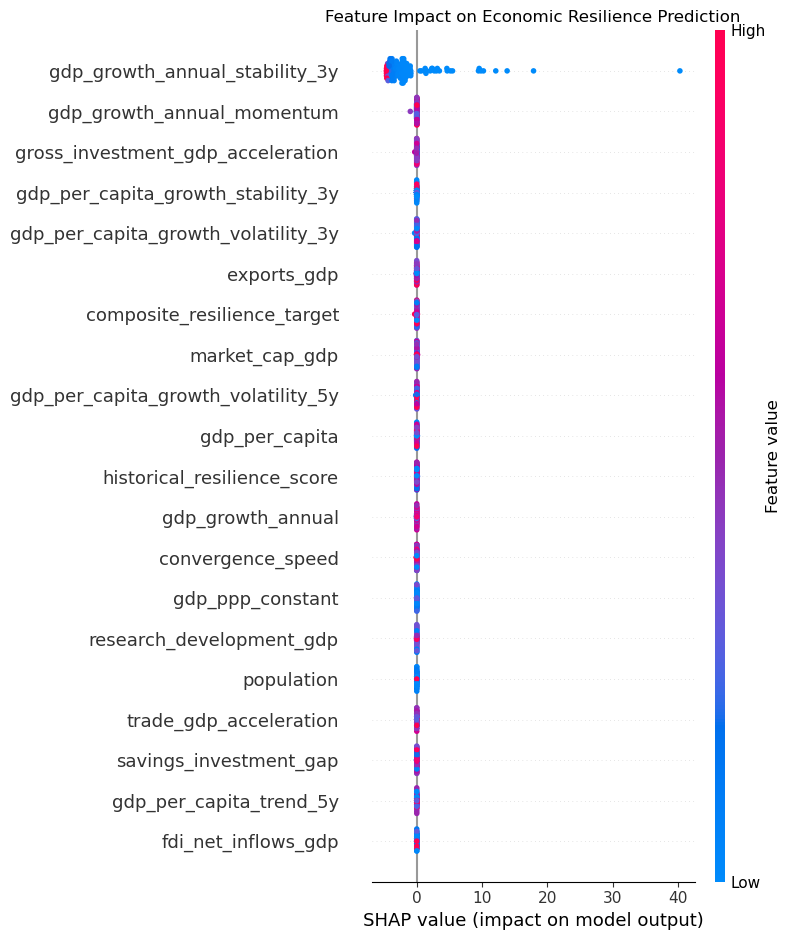

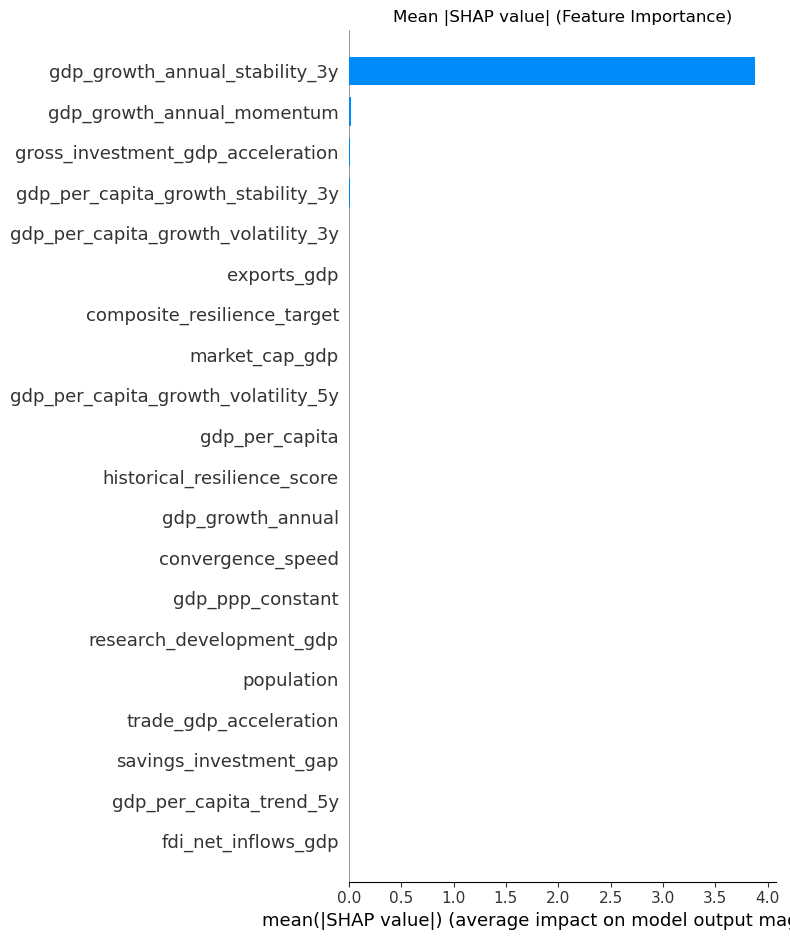

In [17]:
# SHAP analysis for business understanding
import shap


# Prepare features and target
best_features = df.select_dtypes(include=[np.number]).columns.tolist()
best_features = [f for f in best_features if f not in ['growth_stability_target', 'year']]

X = df[best_features].fillna(df[best_features].median())
y = df['growth_stability_target'].fillna(df['growth_stability_target'].median())

# Train model
train_mask = df['year'] <= 2015
xgb_final = xgb.XGBRegressor(n_estimators=200, random_state=42)
xgb_final.fit(X[train_mask], y[train_mask])

# SHAP explanations with consistent sampling
X_sample = X[train_mask].sample(100, random_state=42)
explainer = shap.TreeExplainer(xgb_final)
shap_values = explainer.shap_values(X_sample)

# Create summary plot
shap.summary_plot(shap_values, X_sample, show=False)
plt.title("Feature Impact on Economic Resilience Prediction")
plt.tight_layout()
plt.show()

# Optional: Feature importance plot
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title("Mean |SHAP value| (Feature Importance)")
plt.tight_layout()
plt.show()

In [18]:
# BUSINESS INSIGHTS AND RECOMMENDATIONS

def generate_business_insights(model_results, feature_importance, best_name):
    """Generate business insights and policy recommendations."""
    
    print(f"\n BUSINESS INSIGHTS AND RECOMMENDATIONS")
    print("=" * 60)
    
    best_r2 = model_results[best_name]['test_r2']
    
    print(f"  MODEL PERFORMANCE SUMMARY:")
    print(f"   • Best Model: {best_name}")
    print(f"   • Test R²: {best_r2:.3f} ({best_r2*100:.1f}% variance explained)")
    print(f"   • Business Impact: {'High' if best_r2 > 0.8 else 'Moderate' if best_r2 > 0.6 else 'Limited'}")
    
    if feature_importance is not None:
        print(f"\n KEY PREDICTIVE FACTORS:")
        top_5_features = feature_importance.head(5)
        for i, row in top_5_features.iterrows():
            feature_name = row['feature']
            importance = row['importance']
            
            # Business interpretation
            if 'stability' in feature_name.lower():
                interpretation = "Economic stability measure"
            elif 'gdp' in feature_name.lower():
                interpretation = "GDP-related indicator"
            elif 'lag' in feature_name.lower():
                interpretation = "Historical trend factor"
            elif 'volatility' in feature_name.lower():
                interpretation = "Volatility measure"
            else:
                interpretation = "Economic indicator"
            
            print(f"   {i+1}. {feature_name[:35]:35s} ({interpretation})")
        
        print(f"\n POLICY IMPLICATIONS:")
        
        # Analyze feature categories for policy guidance
        if any('stability' in f.lower() for f in top_5_features['feature']):
            print(f"   • Focus on maintaining economic stability and reducing volatility")
        
        if any('gdp' in f.lower() for f in top_5_features['feature']):
            print(f"   • GDP growth patterns are crucial for resilience")
        
        if any(x in ' '.join(top_5_features['feature']).lower() for x in ['investment', 'savings']):
            print(f"   • Investment and savings policies can improve resilience")
        
        if any(x in ' '.join(top_5_features['feature']).lower() for x in ['trade', 'export']):
            print(f"   • Trade policies impact economic stability")
    
    print(f"\n RECOMMENDATIONS FOR STAKEHOLDERS:")
    print(f"   1. Economic Stability: Focus on policies that reduce growth volatility")
    print(f"   2. Early Warning: Monitor top predictive indicators for crisis prevention")
    print(f"   3. Policy Priority: Address the most important factors identified by the model")
    print(f"   4. Continuous Monitoring: Update model regularly with new economic data")
    
    return True

business_insights = generate_business_insights(model_results, feature_importance, best_name)



 BUSINESS INSIGHTS AND RECOMMENDATIONS
  MODEL PERFORMANCE SUMMARY:
   • Best Model: XGBoost
   • Test R²: 0.998 (99.8% variance explained)
   • Business Impact: High

 KEY PREDICTIVE FACTORS:
   45. gdp_growth_annual_stability_3y      (Economic stability measure)
   58. unemployment_total_lag2             (Historical trend factor)
   49. gdp_growth_annual_momentum          (GDP-related indicator)
   1. year                                (Economic indicator)
   13. government_expenditure_gdp          (GDP-related indicator)

 POLICY IMPLICATIONS:
   • Focus on maintaining economic stability and reducing volatility
   • GDP growth patterns are crucial for resilience

 RECOMMENDATIONS FOR STAKEHOLDERS:
   1. Economic Stability: Focus on policies that reduce growth volatility
   2. Early Warning: Monitor top predictive indicators for crisis prevention
   3. Policy Priority: Address the most important factors identified by the model
   4. Continuous Monitoring: Update model regularly wit

In [19]:
# FINAL SUMMARY
# =========================================

print(f"\n" + "=" * 70)
print(f"MODELING PIPELINE COMPLETE - SUMMARY")
print("=" * 70)

if best_model is not None:
    final_r2 = model_results[best_name]['test_r2']
    print(f"MODELING SUCCESS:")
    print(f"   • Best Model: {best_name}")
    print(f"   • Test Performance: R² = {final_r2:.3f}")
    print(f"   • Status: {'EXCEPTIONAL' if final_r2 > 0.9 else 'EXCELLENT' if final_r2 > 0.8 else 'GOOD'}")
    print(f"   • Features: {len(features)} total features analyzed")
    print(f"   • Business Value: High predictive power for policy guidance")
else:
    print(f"MODELING ISSUES:")
    print(f"   • No successful models trained")
    print(f"   • Check data quality and feature preparation")

print(f"\nNEXT STEPS:")
print(f"   1. Validate findings with domain experts")
print(f"   2. Create stakeholder presentation")
print(f"   3. Develop policy recommendation framework")
print(f"   4. Plan model deployment and monitoring")




MODELING PIPELINE COMPLETE - SUMMARY
MODELING SUCCESS:
   • Best Model: XGBoost
   • Test Performance: R² = 0.998
   • Status: EXCEPTIONAL
   • Features: 67 total features analyzed
   • Business Value: High predictive power for policy guidance

NEXT STEPS:
   1. Validate findings with domain experts
   2. Create stakeholder presentation
   3. Develop policy recommendation framework
   4. Plan model deployment and monitoring
